In [40]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [41]:

path=str(pathlib.Path().resolve())+"/"

In [42]:
df=pd.read_csv(path+"Intel_Market.csv")
df

,Fecha,Cerrar/último,Volumen,Abrir,Alto,Bajo
0,03/04/2024,"40,33",83717980,"41,40","41,65","40,22"
1,02/04/2024,"43,94",32748360,"43,925","44,08","43,50"
2,01/04/2024,"44,52",31712590,"44,29","45,41","44,18"
3,28/03/2024,"44,17",54204190,"43,76","44,60","43,71"
4,27/03/2024,"43,77",51017830,"42,54","43,83","42,50"
...,...,...,...,...,...,...
2511,10/04/2014,"26,425",40390460,"27,01","27,09","26,36"
2512,09/04/2014,"26,98",34467000,"26,93","27,02","26,73"
2513,08/04/2014,"26,91",56564370,"26,36","26,98","26,35"
2514,07/04/2014,"26,485",49693490,"26,30","26,74","26,20"


In [43]:
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y').dt.date
df = df.set_index("Fecha")
df['Cerrar/último'] = df['Cerrar/último'].str.replace(",",".").astype(np.float32)
#df = df[['Cerrar/último']].rolling(7).mean().dropna()
df=df[['Cerrar/último']]

In [44]:
#plt.plot(df['Fecha'],df['Cerrar/último'])

In [45]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0,1))
df_transformed = scaler.fit_transform(df)

In [46]:
X = df_transformed[:-1]
y = df_transformed[1:]

In [47]:
X

array([[0.35414284],
       [0.43699795],
       [0.45030993],
       ...,
       [0.04773927],
       [0.04613268],
       [0.03637826]], dtype=float32)

In [48]:
#from sklearn.preprocessing import LabelEncoder

#l = LabelEncoder()
#X = l.fit_transform(X)

In [49]:
from sklearn.model_selection import train_test_split

value = int(len(X)*0.2)
X_train, y_train, X_test, y_test = X[value:],y[value:],X[:value],y[:value]

In [50]:
import numpy as np


#X_train = np.reshape(X_train, (X_train.shape[0], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], 1))

# Red de una Neurona

In [51]:
"""OJO CON EL RETURN_SEQUENCES"""
def modelo_red_recurrente_3(x_train, y_train,n_neuronas):
    
    # return_sequences significa que solo de salida por Vector no por secuencia, lo que hará que vayan todas de vez
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(n_neuronas, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(n_neuronas, return_sequences=False),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=100)
    return model

In [55]:
from sklearn.metrics import mean_squared_error


modelo = modelo_red_recurrente_3(X_train, y_train,40)
y_pred = modelo.predict(X_test)

rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_recurrente_1 = {rms}")

Epoch 1/100
63/63 [==============================] - 1s 663us/step - loss: 0.0600
Epoch 2/100
63/63 [==============================] - 0s 643us/step - loss: 0.0019
Epoch 3/100
63/63 [==============================] - 0s 655us/step - loss: 5.2559e-04
Epoch 4/100
63/63 [==============================] - 0s 650us/step - loss: 5.0363e-04
Epoch 5/100
63/63 [==============================] - 0s 664us/step - loss: 5.0390e-04
Epoch 6/100
63/63 [==============================] - 0s 661us/step - loss: 5.0828e-04
Epoch 7/100
63/63 [==============================] - 0s 643us/step - loss: 5.0775e-04
Epoch 8/100
63/63 [==============================] - 0s 654us/step - loss: 5.0816e-04
Epoch 9/100
63/63 [==============================] - 0s 667us/step - loss: 5.0847e-04
Epoch 10/100
63/63 [==============================] - 0s 655us/step - loss: 5.0529e-04
Epoch 11/100
63/63 [==============================] - 0s 646us/step - loss: 5.0717e-04
Epoch 12/100
63/63 [==============================] - 0s 654

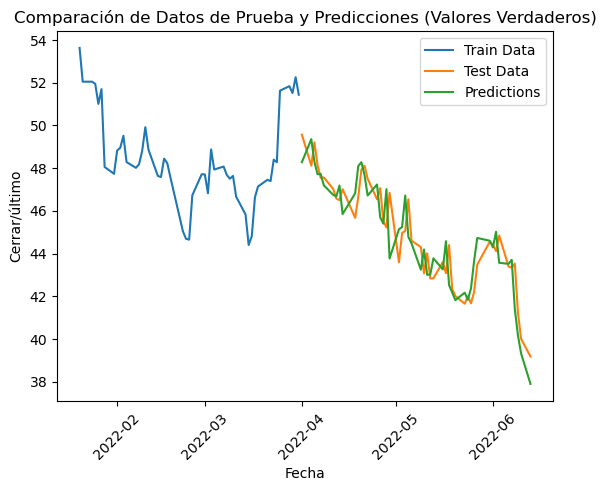

In [56]:
import matplotlib.pyplot as plt

# Concatenar los índices de train y test para plotear
index_train = df.index[len(X_test):][:50]
index_test = df.index[:len(X_test)][-50:]

# Invertir la transformación de MinMaxScaler para obtener los valores verdaderos
y_train_inverse = scaler.inverse_transform(y_train)
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

# Plot de datos de entrenamiento
plt.plot(index_train, y_train_inverse[:50], label='Train Data')

# Plot de datos de prueba
plt.plot(index_test, y_test_inverse[-50:], label='Test Data')

# Plot de predicciones
plt.plot(index_test, y_pred_inverse[-50:], label='Predictions')

plt.title('Comparación de Datos de Prueba y Predicciones (Valores Verdaderos)')
plt.xlabel('Fecha')
plt.ylabel('Cerrar/último')
plt.legend()
plt.xticks(rotation=45)
plt.show()



In [63]:
rnn_predice_1_10 = keras.models.Sequential([
    keras.layers.SimpleRNN(40, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(40, return_sequences=True),
    keras.layers.Dense(10)
    ])
rnn_predice_1_10.compile(loss="mse", optimizer="adam")
rnn_predice_1_10.fit(X_train, y_train, epochs=100)

Epoch 1/100
63/63 [==============================] - 1s 751us/step - loss: 0.0975
Epoch 2/100
63/63 [==============================] - 0s 721us/step - loss: 0.0614
Epoch 3/100
63/63 [==============================] - 0s 701us/step - loss: 0.0582
Epoch 4/100
63/63 [==============================] - 0s 688us/step - loss: 0.0580
Epoch 5/100
63/63 [==============================] - 0s 691us/step - loss: 0.0581
Epoch 6/100
63/63 [==============================] - 0s 707us/step - loss: 0.0581
Epoch 7/100
63/63 [==============================] - 0s 687us/step - loss: 0.0579
Epoch 8/100
63/63 [==============================] - 0s 669us/step - loss: 0.0582
Epoch 9/100
63/63 [==============================] - 0s 685us/step - loss: 0.0583
Epoch 10/100
63/63 [==============================] - 0s 666us/step - loss: 0.0580
Epoch 11/100
63/63 [==============================] - 0s 665us/step - loss: 0.0580
Epoch 12/100
63/63 [==============================] - 0s 695us/step - loss: 0.0580
Epoch 13/100
